In [12]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from Data import load_df, RandomSimetry, ImMean as IM, ImSTD as IS
from Network import ConvolutionBlock

from tqdm import tqdm

path = "/home/emap/danilo/" + "data6/"
device = "cuda"

IM = IM.to(device)
IS = IS.to(device)

df = load_df(path)
df = df[df["mean"] != 0]
df = df[(df["mean"] < 0.2) | (df["mean"] > 0.5)]

df.head()

,lat,lon,year,month,day,mean,filename
1,-3.59,-54.72,2016,8,1,0.60,Labeled_-3.59_-54.72_2016_08_01_0.60.npy
2,-4.01,-54.76,2021,5,1,0.63,Labeled_-4.01_-54.76_2021_05_01_0.63.npy
6,-3.45,-54.50,2018,8,1,0.15,Labeled_-3.45_-54.50_2018_08_01_0.15.npy
9,-4.31,-54.90,2017,7,1,0.56,Labeled_-4.31_-54.90_2017_07_01_0.56.npy
10,-3.77,-54.74,2018,8,1,0.15,Labeled_-3.77_-54.74_2018_08_01_0.15.npy


In [13]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((64,64)),
            transforms.Normalize(IM, IS),
            RandomSimetry(),
        ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(611, 153)

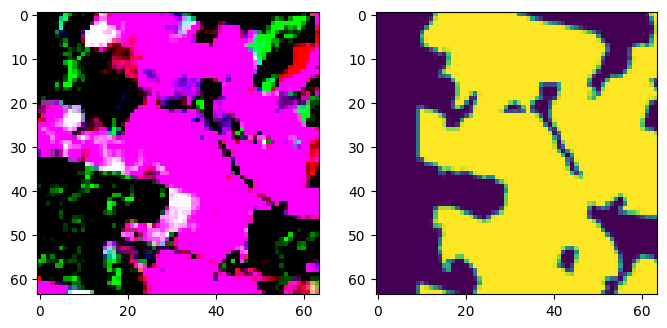

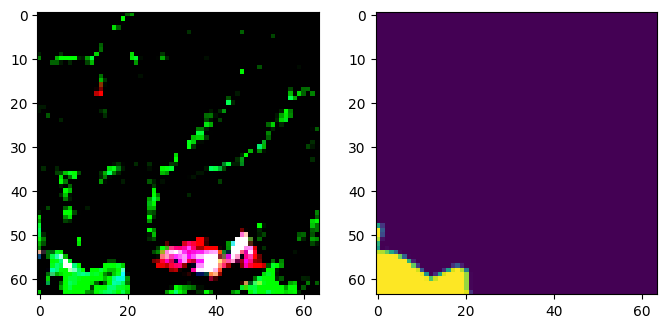

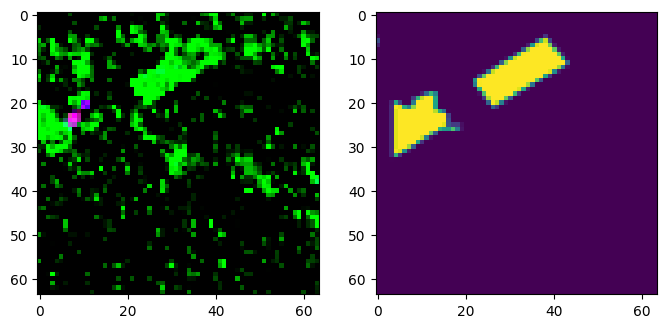

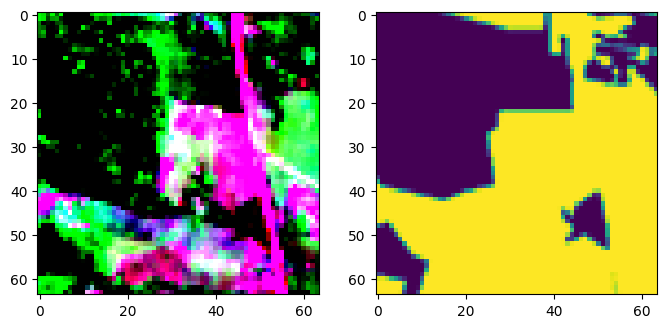

In [14]:
a, b = next(iter(train_dl))
for i in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    axes[0].imshow(a[i][3:6].permute(1, 2, 0).clip(0,1).cpu().numpy())
    axes[1].imshow(b[i].cpu().numpy())

In [15]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            ConvolutionBlock(7, 16, 3),
            ConvolutionBlock(16, 16, 3, residual=True, bias=False),
            ConvolutionBlock(16, 16, 3, residual=True, bias=False),
            nn.AvgPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Dropout(0.4),
            ConvolutionBlock(16, 32, 3),
            ConvolutionBlock(32, 32, 3, residual=True, bias=False),
            ConvolutionBlock(32, 32, 3, residual=True, bias=False),
            nn.AvgPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Dropout(0.4),
            ConvolutionBlock(32, 64, 3),
            ConvolutionBlock(64, 64, 3, residual=True, bias=False),
            ConvolutionBlock(64, 64, 3, residual=True, bias=False),
            
            ConvolutionBlock(64, 1, 1),
        )

        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=(2,3)) + self.bias

        return x

model = Network().to(device)

In [16]:
# Train the model
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = tqdm(range(7001))
def closure():
    global pbar

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    lb = lb.mean(dim=(1, 2))
    lb = (lb >= 0.4).float()[..., None]

    out = model(im)
    loss = loss_fn(out, lb)
    
    pbar.set_description(f"Loss: {loss:.4f}")

    loss.backward()
    return loss

model.train()
for i in pbar:
    optimizer.step(closure)

    if i % 50 == 0:
        model.eval()
        with torch.no_grad():
            im, lb = next(iter(val_dl))
            lb = lb.mean(dim=(1, 2))
            lb = (lb >= 0.4).float()[..., None]
            
            out = model(im)
            ls = loss_fn(out, lb).item()
            
            print(f"Val Loss: {ls:.4f}")
        model.train()

  0%|          | 0/7001 [00:00<?, ?it/s]

Loss: 0.5900:   0%|          | 5/7001 [00:00<13:54,  8.38it/s]  

Val Loss: 0.6922


Loss: 0.5655:   1%|          | 57/7001 [00:02<04:12, 27.48it/s]

Val Loss: 0.5769


Loss: 0.5406:   1%|▏         | 105/7001 [00:03<04:06, 28.03it/s]

Val Loss: 0.5678


Loss: 0.4975:   2%|▏         | 157/7001 [00:05<04:14, 26.92it/s]

Val Loss: 0.5621


Loss: 0.4972:   3%|▎         | 205/7001 [00:07<04:03, 27.87it/s]

Val Loss: 0.5474


Loss: 0.5204:   4%|▎         | 257/7001 [00:08<03:59, 28.10it/s]

Val Loss: 0.5545


Loss: 0.4794:   4%|▍         | 305/7001 [00:10<04:03, 27.50it/s]

Val Loss: 0.5269


Loss: 0.4641:   5%|▌         | 357/7001 [00:11<04:00, 27.66it/s]

Val Loss: 0.5350


Loss: 0.4453:   6%|▌         | 405/7001 [00:13<03:55, 28.06it/s]

Val Loss: 0.4853


Loss: 0.4740:   7%|▋         | 457/7001 [00:15<03:56, 27.69it/s]

Val Loss: 0.4889


Loss: 0.4450:   7%|▋         | 505/7001 [00:16<03:57, 27.41it/s]

Val Loss: 0.5076


Loss: 0.3959:   8%|▊         | 557/7001 [00:18<03:52, 27.74it/s]

Val Loss: 0.4932


Loss: 0.3974:   9%|▊         | 605/7001 [00:19<03:46, 28.27it/s]

Val Loss: 0.4397


Loss: 0.3672:   9%|▉         | 657/7001 [00:21<03:49, 27.68it/s]

Val Loss: 0.4244


Loss: 0.4101:  10%|█         | 705/7001 [00:23<03:48, 27.60it/s]

Val Loss: 0.4418


Loss: 0.3674:  11%|█         | 757/7001 [00:24<03:39, 28.45it/s]

Val Loss: 0.4330


Loss: 0.3600:  11%|█▏        | 805/7001 [00:26<03:39, 28.26it/s]

Val Loss: 0.4207


Loss: 0.3813:  12%|█▏        | 857/7001 [00:27<03:39, 28.00it/s]

Val Loss: 0.4010


Loss: 0.3380:  13%|█▎        | 905/7001 [00:29<03:39, 27.83it/s]

Val Loss: 0.4009


Loss: 0.3166:  14%|█▎        | 957/7001 [00:31<03:37, 27.83it/s]

Val Loss: 0.4028


Loss: 0.2995:  14%|█▍        | 1005/7001 [00:32<03:34, 27.95it/s]

Val Loss: 0.3784


Loss: 0.3221:  15%|█▌        | 1057/7001 [00:34<03:30, 28.22it/s]

Val Loss: 0.4403


Loss: 0.3226:  16%|█▌        | 1105/7001 [00:35<03:30, 27.98it/s]

Val Loss: 0.4154


Loss: 0.2868:  17%|█▋        | 1157/7001 [00:37<03:27, 28.16it/s]

Val Loss: 0.3788


Loss: 0.3971:  17%|█▋        | 1205/7001 [00:38<03:28, 27.79it/s]

Val Loss: 0.3851


Loss: 0.3170:  18%|█▊        | 1257/7001 [00:40<03:26, 27.88it/s]

Val Loss: 0.3571


Loss: 0.3293:  19%|█▊        | 1305/7001 [00:42<03:23, 27.97it/s]

Val Loss: 0.3655


Loss: 0.2586:  19%|█▉        | 1357/7001 [00:43<03:22, 27.86it/s]

Val Loss: 0.3738


Loss: 0.2507:  20%|██        | 1405/7001 [00:45<03:16, 28.41it/s]

Val Loss: 0.3474


Loss: 0.3445:  21%|██        | 1457/7001 [00:46<03:22, 27.42it/s]

Val Loss: 0.3986


Loss: 0.2275:  21%|██▏       | 1505/7001 [00:48<03:20, 27.44it/s]

Val Loss: 0.3318


Loss: 0.2932:  22%|██▏       | 1557/7001 [00:50<03:14, 27.93it/s]

Val Loss: 0.3830


Loss: 0.2457:  23%|██▎       | 1605/7001 [00:51<03:11, 28.24it/s]

Val Loss: 0.3430


Loss: 0.2689:  24%|██▎       | 1657/7001 [00:53<03:11, 27.92it/s]

Val Loss: 0.3303


Loss: 0.3098:  24%|██▍       | 1705/7001 [00:54<03:11, 27.63it/s]

Val Loss: 0.3117


Loss: 0.2172:  25%|██▌       | 1757/7001 [00:56<03:08, 27.78it/s]

Val Loss: 0.3206


Loss: 0.2737:  26%|██▌       | 1805/7001 [00:57<03:07, 27.72it/s]

Val Loss: 0.3282


Loss: 0.2317:  27%|██▋       | 1857/7001 [00:59<03:04, 27.83it/s]

Val Loss: 0.3117


Loss: 0.2268:  27%|██▋       | 1905/7001 [01:01<03:01, 28.02it/s]

Val Loss: 0.3543


Loss: 0.2812:  28%|██▊       | 1957/7001 [01:02<02:57, 28.49it/s]

Val Loss: 0.3062


Loss: 0.3261:  29%|██▊       | 2005/7001 [01:04<02:57, 28.16it/s]

Val Loss: 0.2980


Loss: 0.2018:  29%|██▉       | 2057/7001 [01:05<02:57, 27.89it/s]

Val Loss: 0.2656


Loss: 0.2491:  30%|███       | 2105/7001 [01:07<02:57, 27.62it/s]

Val Loss: 0.3026


Loss: 0.2423:  31%|███       | 2157/7001 [01:09<02:55, 27.58it/s]

Val Loss: 0.3113


Loss: 0.2002:  31%|███▏      | 2205/7001 [01:10<02:50, 28.19it/s]

Val Loss: 0.2886


Loss: 0.2146:  32%|███▏      | 2257/7001 [01:12<02:53, 27.39it/s]

Val Loss: 0.2843


Loss: 0.2508:  33%|███▎      | 2305/7001 [01:13<02:49, 27.77it/s]

Val Loss: 0.2670


Loss: 0.2243:  34%|███▎      | 2357/7001 [01:15<02:47, 27.71it/s]

Val Loss: 0.2793


Loss: 0.2542:  34%|███▍      | 2405/7001 [01:17<02:41, 28.39it/s]

Val Loss: 0.2856


Loss: 0.2122:  35%|███▌      | 2457/7001 [01:18<02:42, 27.93it/s]

Val Loss: 0.2864


Loss: 0.2115:  36%|███▌      | 2505/7001 [01:20<02:43, 27.54it/s]

Val Loss: 0.2892


Loss: 0.1569:  37%|███▋      | 2557/7001 [01:21<02:36, 28.32it/s]

Val Loss: 0.2546


Loss: 0.1910:  37%|███▋      | 2605/7001 [01:23<02:36, 28.09it/s]

Val Loss: 0.2617


Loss: 0.2311:  38%|███▊      | 2657/7001 [01:24<02:35, 27.93it/s]

Val Loss: 0.2628


Loss: 0.3808:  39%|███▊      | 2705/7001 [01:26<02:33, 27.90it/s]

Val Loss: 0.2612


Loss: 0.1906:  39%|███▉      | 2757/7001 [01:28<02:32, 27.88it/s]

Val Loss: 0.2872


Loss: 0.1938:  40%|████      | 2805/7001 [01:29<02:30, 27.85it/s]

Val Loss: 0.2687


Loss: 0.2236:  41%|████      | 2857/7001 [01:31<02:30, 27.46it/s]

Val Loss: 0.2465


Loss: 0.2604:  41%|████▏     | 2905/7001 [01:32<02:26, 27.93it/s]

Val Loss: 0.3051


Loss: 0.2339:  42%|████▏     | 2957/7001 [01:34<02:24, 27.98it/s]

Val Loss: 0.2693


Loss: 0.1812:  43%|████▎     | 3005/7001 [01:36<02:24, 27.61it/s]

Val Loss: 0.2817


Loss: 0.1983:  44%|████▎     | 3057/7001 [01:37<02:19, 28.34it/s]

Val Loss: 0.2757


Loss: 0.2009:  44%|████▍     | 3105/7001 [01:39<02:19, 27.89it/s]

Val Loss: 0.2746


Loss: 0.2017:  45%|████▌     | 3157/7001 [01:40<02:17, 28.03it/s]

Val Loss: 0.2703


Loss: 0.1879:  46%|████▌     | 3205/7001 [01:42<02:14, 28.13it/s]

Val Loss: 0.2302


Loss: 0.1855:  47%|████▋     | 3257/7001 [01:44<02:14, 27.78it/s]

Val Loss: 0.2353


Loss: 0.1531:  47%|████▋     | 3305/7001 [01:45<02:13, 27.66it/s]

Val Loss: 0.2610


Loss: 0.1480:  48%|████▊     | 3357/7001 [01:47<02:10, 28.02it/s]

Val Loss: 0.2325


Loss: 0.2634:  49%|████▊     | 3405/7001 [01:48<02:07, 28.21it/s]

Val Loss: 0.2210


Loss: 0.1726:  49%|████▉     | 3457/7001 [01:50<02:06, 28.12it/s]

Val Loss: 0.2228


Loss: 0.0933:  50%|█████     | 3505/7001 [01:51<02:06, 27.56it/s]

Val Loss: 0.2419


Loss: 0.1724:  51%|█████     | 3557/7001 [01:53<02:03, 27.86it/s]

Val Loss: 0.2500


Loss: 0.1771:  51%|█████▏    | 3605/7001 [01:55<02:01, 27.92it/s]

Val Loss: 0.2471


Loss: 0.2216:  52%|█████▏    | 3657/7001 [01:56<01:58, 28.33it/s]

Val Loss: 0.2485


Loss: 0.1373:  53%|█████▎    | 3705/7001 [01:58<01:56, 28.17it/s]

Val Loss: 0.2736


Loss: 0.1216:  54%|█████▎    | 3757/7001 [01:59<01:55, 28.20it/s]

Val Loss: 0.2124


Loss: 0.1327:  54%|█████▍    | 3805/7001 [02:01<01:52, 28.44it/s]

Val Loss: 0.2412


Loss: 0.1341:  55%|█████▌    | 3857/7001 [02:02<01:52, 27.92it/s]

Val Loss: 0.2096


Loss: 0.1392:  56%|█████▌    | 3905/7001 [02:04<01:51, 27.77it/s]

Val Loss: 0.2464


Loss: 0.1243:  57%|█████▋    | 3957/7001 [02:06<01:49, 27.90it/s]

Val Loss: 0.2301


Loss: 0.0908:  57%|█████▋    | 4005/7001 [02:07<01:46, 28.21it/s]

Val Loss: 0.2372


Loss: 0.2326:  58%|█████▊    | 4057/7001 [02:09<01:44, 28.15it/s]

Val Loss: 0.2138


Loss: 0.2533:  59%|█████▊    | 4105/7001 [02:10<01:43, 27.89it/s]

Val Loss: 0.2115


Loss: 0.1115:  59%|█████▉    | 4157/7001 [02:12<01:41, 28.02it/s]

Val Loss: 0.2549


Loss: 0.1940:  60%|██████    | 4205/7001 [02:14<01:41, 27.61it/s]

Val Loss: 0.2555


Loss: 0.1039:  61%|██████    | 4257/7001 [02:15<01:38, 27.91it/s]

Val Loss: 0.2367


Loss: 0.1230:  61%|██████▏   | 4305/7001 [02:17<01:38, 27.47it/s]

Val Loss: 0.2304


Loss: 0.0669:  62%|██████▏   | 4357/7001 [02:18<01:35, 27.82it/s]

Val Loss: 0.2206


Loss: 0.1818:  63%|██████▎   | 4405/7001 [02:20<01:32, 27.92it/s]

Val Loss: 0.2535


Loss: 0.1457:  64%|██████▎   | 4456/7001 [02:21<01:36, 26.34it/s]

Val Loss: 0.2145


Loss: 0.2550:  64%|██████▍   | 4504/7001 [02:23<01:37, 25.64it/s]

Val Loss: 0.2336


Loss: 0.1986:  65%|██████▌   | 4556/7001 [02:25<01:25, 28.52it/s]

Val Loss: 0.2563


Loss: 0.2225:  66%|██████▌   | 4604/7001 [02:26<01:31, 26.31it/s]

Val Loss: 0.2330


Loss: 0.1120:  67%|██████▋   | 4656/7001 [02:28<01:22, 28.46it/s]

Val Loss: 0.2303


Loss: 0.1700:  67%|██████▋   | 4704/7001 [02:29<01:27, 26.11it/s]

Val Loss: 0.2612


Loss: 0.1392:  68%|██████▊   | 4756/7001 [02:31<01:19, 28.26it/s]

Val Loss: 0.2701


Loss: 0.0612:  69%|██████▊   | 4804/7001 [02:32<01:24, 26.11it/s]

Val Loss: 0.2166


Loss: 0.0919:  69%|██████▉   | 4856/7001 [02:34<01:15, 28.26it/s]

Val Loss: 0.1814


Loss: 0.1130:  70%|███████   | 4904/7001 [02:36<01:20, 26.13it/s]

Val Loss: 0.2310


Loss: 0.0758:  71%|███████   | 4956/7001 [02:37<01:13, 27.71it/s]

Val Loss: 0.2540


Loss: 0.0823:  71%|███████▏  | 5004/7001 [02:39<01:18, 25.53it/s]

Val Loss: 0.2316


Loss: 0.1629:  72%|███████▏  | 5056/7001 [02:40<01:10, 27.75it/s]

Val Loss: 0.2242


Loss: 0.1566:  73%|███████▎  | 5104/7001 [02:42<01:12, 26.18it/s]

Val Loss: 0.1775


Loss: 0.0657:  74%|███████▎  | 5156/7001 [02:44<01:05, 27.98it/s]

Val Loss: 0.2089


Loss: 0.1861:  74%|███████▍  | 5208/7001 [02:45<01:03, 28.15it/s]

Val Loss: 0.2492


Loss: 0.0642:  75%|███████▌  | 5256/7001 [02:47<01:02, 28.08it/s]

Val Loss: 0.1902


Loss: 0.1266:  76%|███████▌  | 5304/7001 [02:48<01:05, 25.84it/s]

Val Loss: 0.1888


Loss: 0.0789:  77%|███████▋  | 5356/7001 [02:50<00:58, 28.22it/s]

Val Loss: 0.2076


Loss: 0.0749:  77%|███████▋  | 5404/7001 [02:51<01:01, 26.05it/s]

Val Loss: 0.2496


Loss: 0.1124:  78%|███████▊  | 5456/7001 [02:53<00:55, 27.77it/s]

Val Loss: 0.1863


Loss: 0.2827:  79%|███████▊  | 5504/7001 [02:55<00:57, 26.13it/s]

Val Loss: 0.2068


Loss: 0.0984:  79%|███████▉  | 5556/7001 [02:56<00:51, 27.92it/s]

Val Loss: 0.2091


Loss: 0.1144:  80%|████████  | 5604/7001 [02:58<00:53, 26.26it/s]

Val Loss: 0.2131


Loss: 0.0550:  81%|████████  | 5656/7001 [02:59<00:48, 27.75it/s]

Val Loss: 0.2049


Loss: 0.1066:  81%|████████▏ | 5704/7001 [03:01<00:50, 25.43it/s]

Val Loss: 0.2857


Loss: 0.1348:  82%|████████▏ | 5756/7001 [03:03<00:45, 27.14it/s]

Val Loss: 0.1965


Loss: 0.1631:  83%|████████▎ | 5804/7001 [03:04<00:46, 25.68it/s]

Val Loss: 0.2353


Loss: 0.0705:  84%|████████▎ | 5856/7001 [03:06<00:41, 27.77it/s]

Val Loss: 0.1809


Loss: 0.1756:  84%|████████▍ | 5904/7001 [03:07<00:42, 25.59it/s]

Val Loss: 0.2100


Loss: 0.1697:  85%|████████▌ | 5956/7001 [03:09<00:36, 28.25it/s]

Val Loss: 0.2428


Loss: 0.0481:  86%|████████▌ | 6004/7001 [03:11<00:38, 25.86it/s]

Val Loss: 0.1948


Loss: 0.2330:  87%|████████▋ | 6056/7001 [03:12<00:33, 28.19it/s]

Val Loss: 0.1999


Loss: 0.1196:  87%|████████▋ | 6104/7001 [03:14<00:34, 26.08it/s]

Val Loss: 0.2253


Loss: 0.1060:  88%|████████▊ | 6156/7001 [03:15<00:30, 27.84it/s]

Val Loss: 0.1838


Loss: 0.2856:  89%|████████▊ | 6204/7001 [03:17<00:30, 25.98it/s]

Val Loss: 0.2146


Loss: 0.1242:  89%|████████▉ | 6256/7001 [03:18<00:26, 27.76it/s]

Val Loss: 0.1949


Loss: 0.1781:  90%|█████████ | 6304/7001 [03:20<00:26, 26.27it/s]

Val Loss: 0.1883


Loss: 0.0769:  91%|█████████ | 6356/7001 [03:22<00:23, 27.04it/s]

Val Loss: 0.1986


Loss: 0.1400:  91%|█████████▏| 6404/7001 [03:23<00:22, 26.66it/s]

Val Loss: 0.2093


Loss: 0.1557:  92%|█████████▏| 6456/7001 [03:25<00:19, 28.44it/s]

Val Loss: 0.2187


Loss: 0.0432:  93%|█████████▎| 6504/7001 [03:26<00:18, 26.28it/s]

Val Loss: 0.2609


Loss: 0.1161:  94%|█████████▎| 6556/7001 [03:28<00:16, 27.53it/s]

Val Loss: 0.2058


Loss: 0.2169:  94%|█████████▍| 6604/7001 [03:29<00:15, 25.70it/s]

Val Loss: 0.2145


Loss: 0.0540:  95%|█████████▌| 6656/7001 [03:31<00:12, 27.82it/s]

Val Loss: 0.2310


Loss: 0.1082:  96%|█████████▌| 6704/7001 [03:33<00:11, 25.49it/s]

Val Loss: 0.1965


Loss: 0.1392:  97%|█████████▋| 6756/7001 [03:34<00:08, 27.67it/s]

Val Loss: 0.2150


Loss: 0.0575:  97%|█████████▋| 6804/7001 [03:36<00:07, 25.58it/s]

Val Loss: 0.1732


Loss: 0.0862:  98%|█████████▊| 6856/7001 [03:37<00:05, 27.66it/s]

Val Loss: 0.2275


Loss: 0.1076:  99%|█████████▊| 6904/7001 [03:39<00:03, 25.84it/s]

Val Loss: 0.2290


Loss: 0.0925:  99%|█████████▉| 6956/7001 [03:41<00:01, 28.02it/s]

Val Loss: 0.2289


Loss: 0.0993: 100%|██████████| 7001/7001 [03:42<00:00, 31.46it/s]

Val Loss: 0.2386


In [17]:
model.eval()
np.set_printoptions(suppress=True)

im, lb = next(iter(val_dl))
a = model(im).cpu().detach().numpy().flatten()
a, lb.mean(dim=(1, 2)) > 0.4

(array([-3.3368053 , -1.394316  ,  3.294561  , -2.680512  , -3.4611201 ,
         4.6263556 ,  1.5369735 ,  2.3557591 , -3.0142422 ,  2.51012   ,
        -3.4611201 ,  3.901919  , -2.87363   ,  1.1349988 , -3.4611201 ,
        -3.4611201 , -3.2639425 ,  4.114445  ,  2.7148237 , -3.4611201 ,
         3.337932  ,  0.58255434,  2.990603  ,  5.14066   ,  5.068938  ,
        -2.1729546 ,  3.4713526 ,  3.8619266 ,  3.960752  , -3.4611201 ,
         4.6458507 ,  4.743709  , -3.3724656 , -2.9973838 , -3.4058633 ,
        -3.0219936 ,  0.322186  , -3.4390562 ,  0.60693216, -3.4611201 ,
        -3.4219594 , -1.0285025 ,  4.9004216 , -3.4611201 ,  0.14958191,
         3.865603  , -3.214913  ,  1.3388014 ,  1.1648717 , -2.6964095 ,
         4.311459  ,  2.5348434 , -3.4611201 , -3.4311934 ,  1.2943063 ,
        -3.4611201 , -3.4611201 ,  4.991347  , -2.4253185 , -3.4606557 ,
        -3.4611201 , -3.4611201 , -3.4089072 , -3.4611201 ,  3.1397128 ,
        -2.8722992 , -3.3970735 , -2.0544834 ,  1.2

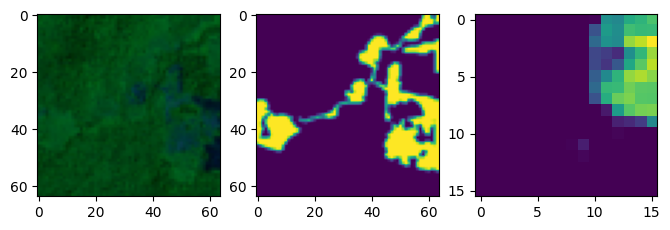

In [20]:
model.eval()

im, lb = next(iter(train_dl))
im = im[0]; lb = lb[0]

c1 = model.get_submodule("conv1")
c2 = model.get_submodule("conv2")
c3 = model.get_submodule("conv3")

features_blobs = c3(c2(c1(im[None, ...])))

im = (im[3:6] * IS[3:6, None, None]) + IM[3:6, None, None]

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
axes[0].imshow(im.permute(1, 2, 0).clip(0,1).cpu().numpy())
axes[1].imshow(lb.cpu().detach().numpy())
axes[2].imshow(features_blobs[0][0].cpu().detach().numpy());

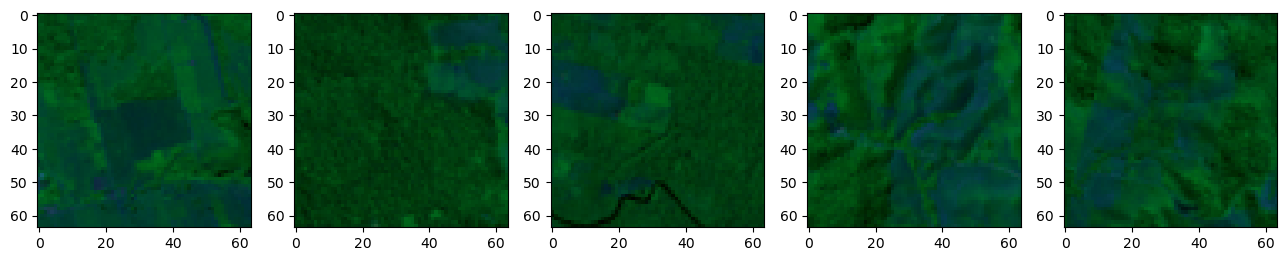

In [19]:
im, lb = next(iter(train_dl))
im = (im[:, 3:6] * IS[None, 3:6, None, None]) + IM[None, 3:6, None, None]

fig, axes = plt.subplots(1, 5, figsize=(16, 8))
for i in range(5):
    axes[i].imshow(im[i].permute(1, 2, 0).clip(0,1).cpu().numpy())